In [12]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter
from helper import preprocess_catalog_galactic
from helper import load_catalog
from helper import symmetrize_map
from helper import radial_profile
import pandas as pd

In [13]:
# --- Settings ---
dataset = "BOSS"
if dataset == "eBOSS":
    catalog, region = "LRG", "NGC"
    real_file = f"data/eBOSS/eBOSS_{catalog}_clustering_data-{region}-vDR16.fits"
    rand_file = f"data/eBOSS/eBOSS_LRG_clustering_random-{region}-vDR16.fits"
elif dataset == "BOSS":
    catalog, region = "CMASS", "North"
    real_file = f"data/BOSS/galaxy_DR12v5_CMASS_{region}.fits"
    rand_file = f"data/BOSS/random0_DR12v5_CMASS_{region}.fits"
else:
    raise ValueError("dataset must be eBOSS or BOSS")

alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"

In [14]:
nside = 2048
fwhm_rad = np.radians(8 / 60)
box_size_hmpc = 100.0
h = cosmo.h
grid_size = 100
cell_size_hmpc = box_size_hmpc / grid_size
half_box_hmpc = box_size_hmpc / 2
extent = [-half_box_hmpc, half_box_hmpc, -half_box_hmpc, half_box_hmpc]

offsets = np.linspace(-half_box_hmpc + cell_size_hmpc/2,
                      half_box_hmpc - cell_size_hmpc/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x, off_y = off_x.ravel(), off_y.ravel()

In [15]:
# --- Load κ map and mask ---
alm_data = fits.open(alm_file)[1].data
alm = alm_data['REAL'] + 1j * alm_data['IMAG']
lmax = hp.Alm.getlmax(len(alm))
kmap = hp.alm2map(hp.smoothalm(alm, fwhm=fwhm_rad), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

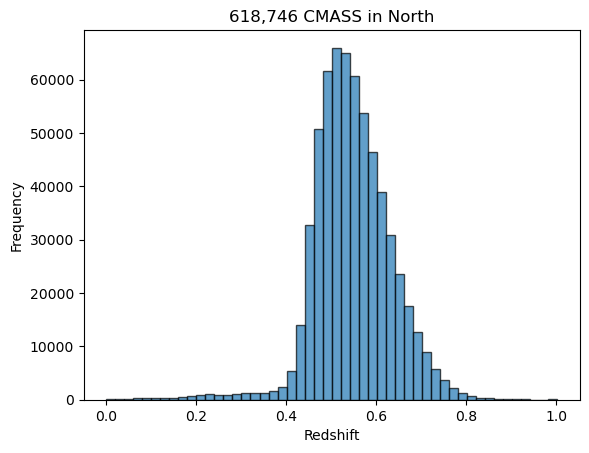

In [16]:
from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# --- Load eBOSS LRG catalog ---
with fits.open(real_file) as hd:
    data = hd[1].data

# --- Filter out invalid galaxies ---
data = data[data['Z'] > 0]
data = data[np.isfinite(data['RA']) & np.isfinite(data['DEC'])]

# --- Load and smooth Planck κ alm ---
alms = fits.open("data/COM_Lensing_4096_R3.00/MV/dat_klm.fits")[1].data
alm = alms['REAL'] + 1j * alms['IMAG']
lmax = hp.Alm.getlmax(len(alm))
nside = 2048

# --- Redshift histogram ---
zs = [gal['Z'] for gal in data]
plt.hist(zs, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.title(f"{len(zs):,} {catalog} in {region}")
plt.show()

In [17]:
def assign_jackknife_regions_healpix(catalog, rand_cat, nside=10, threshold=0.9):
    rand_coord = SkyCoord(ra=rand_cat['RA']*u.deg, dec=rand_cat['DEC']*u.deg)
    rand_pix = hp.ang2pix(nside, np.radians(90 - rand_coord.dec.value), np.radians(rand_coord.ra.value))

    unique, counts = np.unique(rand_pix, return_counts=True)
    mean_density = np.mean(counts)
    good_pix = unique[counts > threshold * mean_density]

    gal_coord = SkyCoord(ra=catalog['RA']*u.deg, dec=catalog['DEC']*u.deg)
    gal_pix = hp.ang2pix(nside, np.radians(90 - gal_coord.dec.value), np.radians(gal_coord.ra.value))

    mask = np.isin(gal_pix, good_pix)
    return gal_pix[mask], mask

In [18]:
# --- κ stacker ---
def stack_kappa(data, weights, label):
    sz = grid_size**2
    sum_wk = np.zeros(sz)
    sum_wk2 = np.zeros(sz)
    sum_w = np.zeros(sz)

    # --- Preprocess only valid galaxies and convert to Galactic ---
    l_arr, b_arr, D_arr, data, weights_valid = preprocess_catalog_galactic(data, weights)
    # weights = weights[:len(data)]  # Ensure weights match filtered data

    for i in tqdm(range(len(data)), desc=f"Stacking {label}"):
        l = l_arr[i]
        b = b_arr[i]
        D = D_arr[i]

        cosb = np.cos(np.radians(b))
        dl = (off_x / D) * (180 / np.pi) / np.clip(cosb, 1e-6, None)
        db = (off_y / D) * (180 / np.pi)

        l_grid = l + dl
        b_grid = b + db

        theta = np.radians(90 - b_grid)
        # if np.minimum(theta) < 0:
            # print(f"{i}: Theta less than zero encountered: {np.min(theta)}")
            # continue
        # if np.maximum(theta) > np.pi:
            # print(f"{i}: Theta greater than zero encountered: {np.max(theta)}")
            # continue
        phi = np.radians(l_grid)
        theta = np.clip(theta, 0, np.pi)  # Ensure valid range
        pix = hp.ang2pix(nside, theta, phi)

        w = weights_valid[i] * mask[pix]
        if np.sum(w) == 0:
            continue

        κ_vals = kmap[pix]
        sum_wk += w * κ_vals
        sum_wk2 += w * κ_vals**2
        sum_w += w

    valid = sum_w > 0
    κ_mean = np.zeros_like(sum_w)
    κ_var = np.zeros_like(sum_w)
    κ_mean[valid] = sum_wk[valid] / sum_w[valid]
    κ_var[valid] = sum_wk2[valid] / sum_w[valid] - κ_mean[valid]**2
    κ_sigma = np.zeros_like(κ_var)
    κ_sigma[valid] = np.sqrt(κ_var[valid]) / np.sqrt(sum_w[valid])
    κ_sn = np.zeros_like(κ_mean)
    κ_sn[valid & (κ_sigma > 0)] = κ_mean[valid & (κ_sigma > 0)] / κ_sigma[valid & (κ_sigma > 0)]

    return κ_mean.reshape(grid_size, grid_size), κ_sigma.reshape(grid_size, grid_size), κ_sn.reshape(grid_size, grid_size)

In [19]:
def jackknife_stack_healpix(data, weights, rand_cat, nside=10, threshold=0.9):
    print("Assigning jackknife regions...")
    jk_regions, valid_mask = assign_jackknife_regions_healpix(data, rand_cat, nside, threshold)
    data, weights = data[valid_mask], weights[valid_mask]
    unique_regions = np.unique(jk_regions)

    kappa_jk = []

    for reg in tqdm(unique_regions, desc="Jackknife (HEALPix)"):
        mask_jk = jk_regions != reg
        data_jk = data[mask_jk]
        weights_jk = weights[mask_jk]
        kappa, _, _ = stack_kappa(data_jk, weights_jk, f"JK-{reg}")
        kappa_jk.append(kappa)

    kappa_jk = np.array(kappa_jk)
    kappa_mean = np.mean(kappa_jk, axis=0)
    kappa_err = np.sqrt((len(kappa_jk) - 1) / len(kappa_jk) * np.sum((kappa_jk - kappa_mean)**2, axis=0))

    return kappa_mean, kappa_err

In [20]:
# --- Plotting ---
def plot_map(arr, title, cmap='viridis', label='κ'):
    plt.imshow(arr, origin='lower', extent=extent, cmap=cmap)
    plt.colorbar(label=label)
    plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
    plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
    plt.title(title)
    plt.show()

In [21]:
# --- Run all ---
if dataset == "BOSS":
    z_min = .4
    z_max = .7
    weight = "CMASS"
else: # eBOSS
    z_min = 0
    z_max = 10000
    weight = True
print("Loading catalogs...")
data_real, w_real = load_catalog(real_file, weights=weight, z_min=z_min, z_max=z_max)
print("Loading random catalogs...")
data_rand, w_rand = load_catalog(rand_file, weights=False, random_fraction=0.001, z_min=z_min, z_max=z_max)

# Jackknife real galaxies
kappa_real, sigma_real = jackknife_stack_healpix(data_real, w_real, data_rand, nside=10)
sn_real = np.zeros_like(kappa_real)
valid = sigma_real > 0
sn_real[valid] = kappa_real[valid] / sigma_real[valid]
kappa_rand, sigma_rand, sn_rand = stack_kappa(data_rand, w_rand, "Random")
kappa_sub = kappa_real - kappa_rand
# kappa_smooth = gaussian_filter(kappa_sub, sigma=2)

Loading catalogs...
Loading random catalogs...
Assigning jackknife regions...


Jackknife (HEALPix):   0%|          | 0/193 [00:00<?, ?it/s]

Stacking JK-50:   0%|          | 0/516414 [00:00<?, ?it/s]

Stacking JK-69:   0%|          | 0/516410 [00:00<?, ?it/s]

Stacking JK-70:   0%|          | 0/516213 [00:00<?, ?it/s]

Stacking JK-71:   0%|          | 0/516101 [00:00<?, ?it/s]

Stacking JK-72:   0%|          | 0/515900 [00:00<?, ?it/s]

Stacking JK-73:   0%|          | 0/515673 [00:00<?, ?it/s]

Stacking JK-74:   0%|          | 0/515879 [00:00<?, ?it/s]

Stacking JK-94:   0%|          | 0/516022 [00:00<?, ?it/s]

Stacking JK-95:   0%|          | 0/516441 [00:00<?, ?it/s]

Stacking JK-96:   0%|          | 0/515728 [00:00<?, ?it/s]

Stacking JK-97:   0%|          | 0/515844 [00:00<?, ?it/s]

Stacking JK-98:   0%|          | 0/515905 [00:00<?, ?it/s]

Stacking JK-99:   0%|          | 0/515560 [00:00<?, ?it/s]

Stacking JK-100:   0%|          | 0/515666 [00:00<?, ?it/s]

Stacking JK-101:   0%|          | 0/515900 [00:00<?, ?it/s]

Stacking JK-102:   0%|          | 0/516328 [00:00<?, ?it/s]

Stacking JK-123:   0%|          | 0/516412 [00:00<?, ?it/s]

Stacking JK-124:   0%|          | 0/515718 [00:00<?, ?it/s]

Stacking JK-125:   0%|          | 0/515680 [00:00<?, ?it/s]

Stacking JK-126:   0%|          | 0/515451 [00:00<?, ?it/s]

Stacking JK-127:   0%|          | 0/515903 [00:00<?, ?it/s]

Stacking JK-128:   0%|          | 0/516086 [00:00<?, ?it/s]

Stacking JK-129:   0%|          | 0/515716 [00:00<?, ?it/s]

Stacking JK-130:   0%|          | 0/515480 [00:00<?, ?it/s]

Stacking JK-131:   0%|          | 0/515267 [00:00<?, ?it/s]

Stacking JK-132:   0%|          | 0/515871 [00:00<?, ?it/s]

Stacking JK-133:   0%|          | 0/516177 [00:00<?, ?it/s]

Stacking JK-156:   0%|          | 0/516206 [00:00<?, ?it/s]

Stacking JK-158:   0%|          | 0/515815 [00:00<?, ?it/s]

Stacking JK-159:   0%|          | 0/515335 [00:00<?, ?it/s]

Stacking JK-160:   0%|          | 0/515485 [00:00<?, ?it/s]

Stacking JK-161:   0%|          | 0/515971 [00:00<?, ?it/s]

Stacking JK-162:   0%|          | 0/515505 [00:00<?, ?it/s]

Stacking JK-163:   0%|          | 0/515579 [00:00<?, ?it/s]

Stacking JK-164:   0%|          | 0/516023 [00:00<?, ?it/s]

Stacking JK-165:   0%|          | 0/515862 [00:00<?, ?it/s]

Stacking JK-166:   0%|          | 0/515481 [00:00<?, ?it/s]

Stacking JK-167:   0%|          | 0/515830 [00:00<?, ?it/s]

Stacking JK-168:   0%|          | 0/516119 [00:00<?, ?it/s]

Stacking JK-193:   0%|          | 0/516144 [00:00<?, ?it/s]

Stacking JK-194:   0%|          | 0/516016 [00:00<?, ?it/s]

Stacking JK-195:   0%|          | 0/516275 [00:00<?, ?it/s]

Stacking JK-196:   0%|          | 0/515539 [00:00<?, ?it/s]

Stacking JK-197:   0%|          | 0/516046 [00:00<?, ?it/s]

Stacking JK-198:   0%|          | 0/515845 [00:00<?, ?it/s]

Stacking JK-199:   0%|          | 0/515714 [00:00<?, ?it/s]

Stacking JK-200:   0%|          | 0/515831 [00:00<?, ?it/s]

Stacking JK-201:   0%|          | 0/515699 [00:00<?, ?it/s]

Stacking JK-202:   0%|          | 0/516127 [00:00<?, ?it/s]

Stacking JK-203:   0%|          | 0/515696 [00:00<?, ?it/s]

Stacking JK-204:   0%|          | 0/516188 [00:00<?, ?it/s]

Stacking JK-206:   0%|          | 0/515805 [00:00<?, ?it/s]

Stacking JK-207:   0%|          | 0/515950 [00:00<?, ?it/s]

Stacking JK-233:   0%|          | 0/515826 [00:00<?, ?it/s]

Stacking JK-234:   0%|          | 0/515925 [00:00<?, ?it/s]

Stacking JK-235:   0%|          | 0/516134 [00:00<?, ?it/s]

Stacking JK-236:   0%|          | 0/515895 [00:00<?, ?it/s]

Stacking JK-237:   0%|          | 0/515787 [00:00<?, ?it/s]

Stacking JK-238:   0%|          | 0/515985 [00:00<?, ?it/s]

Stacking JK-239:   0%|          | 0/515765 [00:00<?, ?it/s]

Stacking JK-240:   0%|          | 0/515562 [00:00<?, ?it/s]

Stacking JK-241:   0%|          | 0/515654 [00:00<?, ?it/s]

Stacking JK-242:   0%|          | 0/516112 [00:00<?, ?it/s]

Stacking JK-243:   0%|          | 0/515749 [00:00<?, ?it/s]

Stacking JK-244:   0%|          | 0/515614 [00:00<?, ?it/s]

Stacking JK-245:   0%|          | 0/515906 [00:00<?, ?it/s]

Stacking JK-246:   0%|          | 0/516094 [00:00<?, ?it/s]

Stacking JK-247:   0%|          | 0/516079 [00:00<?, ?it/s]

Stacking JK-248:   0%|          | 0/516298 [00:00<?, ?it/s]

Stacking JK-273:   0%|          | 0/515841 [00:00<?, ?it/s]

Stacking JK-274:   0%|          | 0/516009 [00:00<?, ?it/s]

Stacking JK-275:   0%|          | 0/515993 [00:00<?, ?it/s]

Stacking JK-276:   0%|          | 0/515647 [00:00<?, ?it/s]

Stacking JK-277:   0%|          | 0/515720 [00:00<?, ?it/s]

Stacking JK-278:   0%|          | 0/516132 [00:00<?, ?it/s]

Stacking JK-279:   0%|          | 0/516024 [00:00<?, ?it/s]

Stacking JK-280:   0%|          | 0/516102 [00:00<?, ?it/s]

Stacking JK-281:   0%|          | 0/516016 [00:00<?, ?it/s]

Stacking JK-282:   0%|          | 0/516151 [00:00<?, ?it/s]

Stacking JK-283:   0%|          | 0/515716 [00:00<?, ?it/s]

Stacking JK-284:   0%|          | 0/515679 [00:00<?, ?it/s]

Stacking JK-285:   0%|          | 0/516290 [00:00<?, ?it/s]

Stacking JK-286:   0%|          | 0/516058 [00:00<?, ?it/s]

Stacking JK-287:   0%|          | 0/516261 [00:00<?, ?it/s]

Stacking JK-288:   0%|          | 0/516268 [00:00<?, ?it/s]

Stacking JK-313:   0%|          | 0/516523 [00:00<?, ?it/s]

Stacking JK-314:   0%|          | 0/515834 [00:00<?, ?it/s]

Stacking JK-315:   0%|          | 0/515547 [00:00<?, ?it/s]

Stacking JK-316:   0%|          | 0/515771 [00:00<?, ?it/s]

Stacking JK-317:   0%|          | 0/515803 [00:00<?, ?it/s]

Stacking JK-318:   0%|          | 0/515651 [00:00<?, ?it/s]

Stacking JK-319:   0%|          | 0/515824 [00:00<?, ?it/s]

Stacking JK-320:   0%|          | 0/515272 [00:00<?, ?it/s]

Stacking JK-321:   0%|          | 0/515560 [00:00<?, ?it/s]

Stacking JK-322:   0%|          | 0/516244 [00:00<?, ?it/s]

Stacking JK-323:   0%|          | 0/515995 [00:00<?, ?it/s]

Stacking JK-324:   0%|          | 0/515980 [00:00<?, ?it/s]

Stacking JK-325:   0%|          | 0/516379 [00:00<?, ?it/s]

Stacking JK-326:   0%|          | 0/515669 [00:00<?, ?it/s]

Stacking JK-327:   0%|          | 0/515713 [00:00<?, ?it/s]

Stacking JK-328:   0%|          | 0/516138 [00:00<?, ?it/s]

Stacking JK-329:   0%|          | 0/516888 [00:00<?, ?it/s]

Stacking JK-353:   0%|          | 0/516119 [00:00<?, ?it/s]

Stacking JK-354:   0%|          | 0/516156 [00:00<?, ?it/s]

Stacking JK-355:   0%|          | 0/515999 [00:00<?, ?it/s]

Stacking JK-356:   0%|          | 0/515902 [00:00<?, ?it/s]

Stacking JK-357:   0%|          | 0/515855 [00:00<?, ?it/s]

Stacking JK-358:   0%|          | 0/516009 [00:00<?, ?it/s]

Stacking JK-359:   0%|          | 0/515655 [00:00<?, ?it/s]

Stacking JK-360:   0%|          | 0/515624 [00:00<?, ?it/s]

Stacking JK-361:   0%|          | 0/515643 [00:00<?, ?it/s]

Stacking JK-362:   0%|          | 0/515988 [00:00<?, ?it/s]

Stacking JK-363:   0%|          | 0/515803 [00:00<?, ?it/s]

Stacking JK-364:   0%|          | 0/516159 [00:00<?, ?it/s]

Stacking JK-365:   0%|          | 0/515848 [00:00<?, ?it/s]

Stacking JK-366:   0%|          | 0/515862 [00:00<?, ?it/s]

Stacking JK-367:   0%|          | 0/516309 [00:00<?, ?it/s]

Stacking JK-368:   0%|          | 0/516747 [00:00<?, ?it/s]

Stacking JK-393:   0%|          | 0/516289 [00:00<?, ?it/s]

Stacking JK-394:   0%|          | 0/516374 [00:00<?, ?it/s]

Stacking JK-395:   0%|          | 0/515889 [00:00<?, ?it/s]

Stacking JK-396:   0%|          | 0/516032 [00:00<?, ?it/s]

Stacking JK-397:   0%|          | 0/515900 [00:00<?, ?it/s]

Stacking JK-398:   0%|          | 0/515757 [00:00<?, ?it/s]

Stacking JK-399:   0%|          | 0/515866 [00:00<?, ?it/s]

Stacking JK-400:   0%|          | 0/515655 [00:00<?, ?it/s]

Stacking JK-401:   0%|          | 0/515827 [00:00<?, ?it/s]

Stacking JK-402:   0%|          | 0/515826 [00:00<?, ?it/s]

Stacking JK-403:   0%|          | 0/515701 [00:00<?, ?it/s]

Stacking JK-404:   0%|          | 0/516032 [00:00<?, ?it/s]

Stacking JK-405:   0%|          | 0/515905 [00:00<?, ?it/s]

Stacking JK-406:   0%|          | 0/516073 [00:00<?, ?it/s]

Stacking JK-407:   0%|          | 0/516145 [00:00<?, ?it/s]

Stacking JK-408:   0%|          | 0/516216 [00:00<?, ?it/s]

Stacking JK-433:   0%|          | 0/516103 [00:00<?, ?it/s]

Stacking JK-434:   0%|          | 0/516290 [00:00<?, ?it/s]

Stacking JK-435:   0%|          | 0/515683 [00:00<?, ?it/s]

Stacking JK-436:   0%|          | 0/516145 [00:00<?, ?it/s]

Stacking JK-437:   0%|          | 0/515865 [00:00<?, ?it/s]

Stacking JK-438:   0%|          | 0/515823 [00:00<?, ?it/s]

Stacking JK-439:   0%|          | 0/515632 [00:00<?, ?it/s]

Stacking JK-440:   0%|          | 0/515947 [00:00<?, ?it/s]

Stacking JK-441:   0%|          | 0/515534 [00:00<?, ?it/s]

Stacking JK-442:   0%|          | 0/515706 [00:00<?, ?it/s]

Stacking JK-443:   0%|          | 0/516077 [00:00<?, ?it/s]

Stacking JK-444:   0%|          | 0/515878 [00:00<?, ?it/s]

Stacking JK-445:   0%|          | 0/516066 [00:00<?, ?it/s]

Stacking JK-446:   0%|          | 0/515837 [00:00<?, ?it/s]

Stacking JK-447:   0%|          | 0/516057 [00:00<?, ?it/s]

Stacking JK-474:   0%|          | 0/516484 [00:00<?, ?it/s]

Stacking JK-475:   0%|          | 0/516201 [00:00<?, ?it/s]

Stacking JK-476:   0%|          | 0/516027 [00:00<?, ?it/s]

Stacking JK-477:   0%|          | 0/515779 [00:00<?, ?it/s]

Stacking JK-478:   0%|          | 0/516092 [00:00<?, ?it/s]

Stacking JK-479:   0%|          | 0/516010 [00:00<?, ?it/s]

Stacking JK-480:   0%|          | 0/515692 [00:00<?, ?it/s]

Stacking JK-481:   0%|          | 0/515605 [00:00<?, ?it/s]

Stacking JK-482:   0%|          | 0/516082 [00:00<?, ?it/s]

Stacking JK-483:   0%|          | 0/515895 [00:00<?, ?it/s]

Stacking JK-484:   0%|          | 0/515705 [00:00<?, ?it/s]

Stacking JK-485:   0%|          | 0/516115 [00:00<?, ?it/s]

Stacking JK-486:   0%|          | 0/515985 [00:00<?, ?it/s]

Stacking JK-514:   0%|          | 0/516072 [00:00<?, ?it/s]

Stacking JK-515:   0%|          | 0/515661 [00:00<?, ?it/s]

Stacking JK-516:   0%|          | 0/515936 [00:00<?, ?it/s]

Stacking JK-517:   0%|          | 0/516124 [00:00<?, ?it/s]

Stacking JK-518:   0%|          | 0/515771 [00:00<?, ?it/s]

Stacking JK-519:   0%|          | 0/515771 [00:00<?, ?it/s]

Stacking JK-520:   0%|          | 0/515654 [00:00<?, ?it/s]

Stacking JK-521:   0%|          | 0/516082 [00:00<?, ?it/s]

Stacking JK-522:   0%|          | 0/515498 [00:00<?, ?it/s]

Stacking JK-523:   0%|          | 0/515988 [00:00<?, ?it/s]

Stacking JK-524:   0%|          | 0/515593 [00:00<?, ?it/s]

Stacking JK-525:   0%|          | 0/515683 [00:00<?, ?it/s]

Stacking JK-526:   0%|          | 0/516034 [00:00<?, ?it/s]

Stacking JK-554:   0%|          | 0/515774 [00:00<?, ?it/s]

Stacking JK-555:   0%|          | 0/515996 [00:00<?, ?it/s]

Stacking JK-556:   0%|          | 0/515998 [00:00<?, ?it/s]

Stacking JK-560:   0%|          | 0/516093 [00:00<?, ?it/s]

Stacking JK-561:   0%|          | 0/515830 [00:00<?, ?it/s]

Stacking JK-562:   0%|          | 0/516094 [00:00<?, ?it/s]

Stacking JK-563:   0%|          | 0/515729 [00:00<?, ?it/s]

Stacking JK-564:   0%|          | 0/516026 [00:00<?, ?it/s]

Stacking JK-565:   0%|          | 0/516211 [00:00<?, ?it/s]

Stacking JK-566:   0%|          | 0/516337 [00:00<?, ?it/s]

Stacking JK-595:   0%|          | 0/516052 [00:00<?, ?it/s]

Stacking JK-597:   0%|          | 0/516355 [00:00<?, ?it/s]

Stacking JK-598:   0%|          | 0/516408 [00:00<?, ?it/s]

Stacking JK-600:   0%|          | 0/516697 [00:00<?, ?it/s]

Stacking JK-601:   0%|          | 0/516040 [00:00<?, ?it/s]

Stacking JK-602:   0%|          | 0/515676 [00:00<?, ?it/s]

Stacking JK-603:   0%|          | 0/515760 [00:00<?, ?it/s]

Stacking JK-604:   0%|          | 0/515703 [00:00<?, ?it/s]

Stacking Random:   0%|          | 0/30113 [00:00<?, ?it/s]

/Users/carolinewu/PycharmProjects/astrophysics/helper.py:113: RuntimeWarning: invalid value encountered in divide
  kappa_avg = np.bincount(r_flat, weights=kappa_flat) / np.bincount(r_flat)


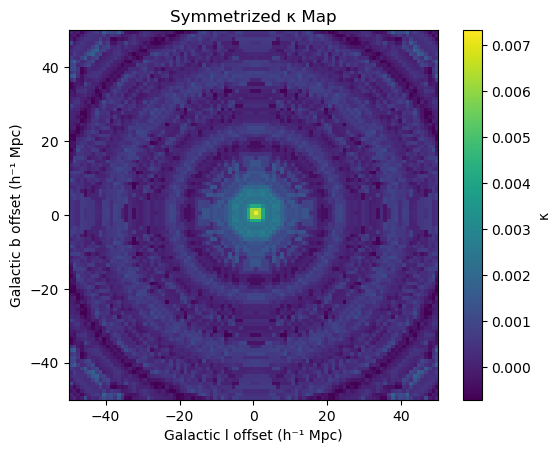

In [22]:
kappa_sym = symmetrize_map(kappa_sub)
plot_map(kappa_sym, "Symmetrized κ Map", cmap='viridis')

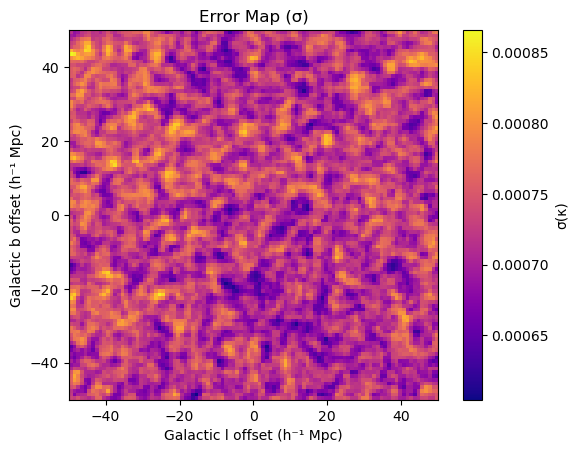

In [23]:
plot_map(sigma_real, "Error Map (σ)", cmap='plasma', label='σ(κ)')

In [24]:
pd.DataFrame(sigma_real).to_csv(r"data/error_map.csv", index=True)

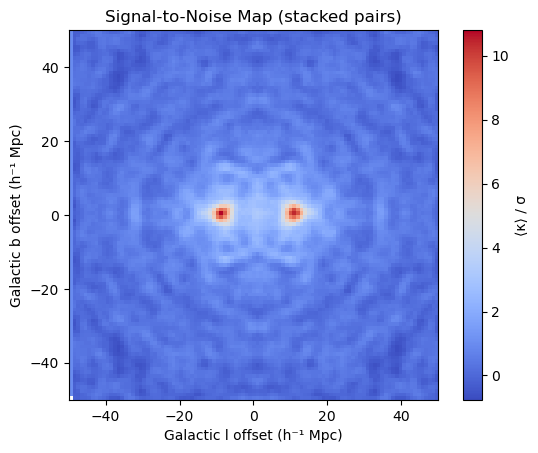

In [29]:
signal_map = pd.read_csv(r"data/signal_map.csv")
error_map = pd.read_csv(r"data/error_map.csv")

sn_real = signal_map / error_map
plot_map(sn_real, "Signal-to-Noise Map (stacked pairs)", cmap='coolwarm', label='⟨κ⟩ / σ')